In [1]:
from zipfile import ZipFile

file_name = "Crema.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


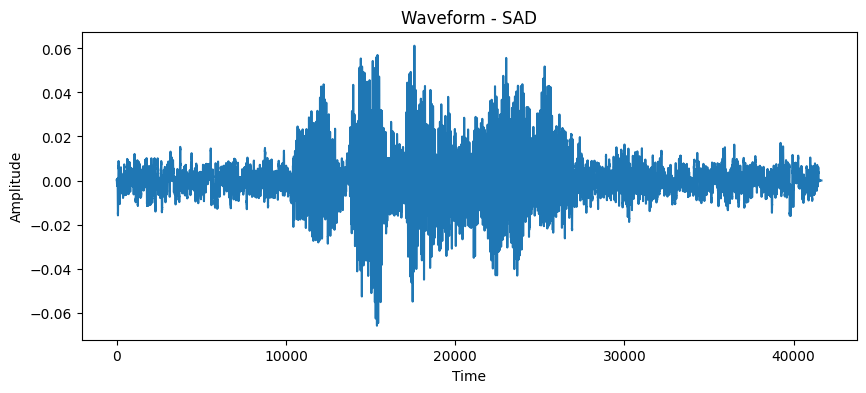

Sadness Audio Sample



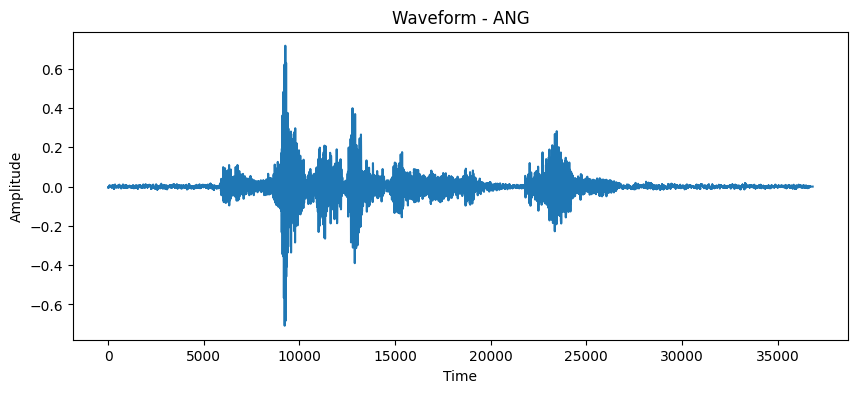

Angry Audio Sample



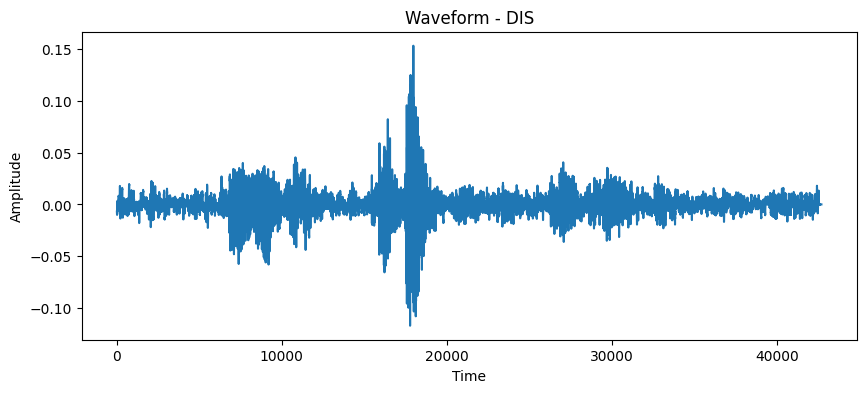

Disgust Audio Sample



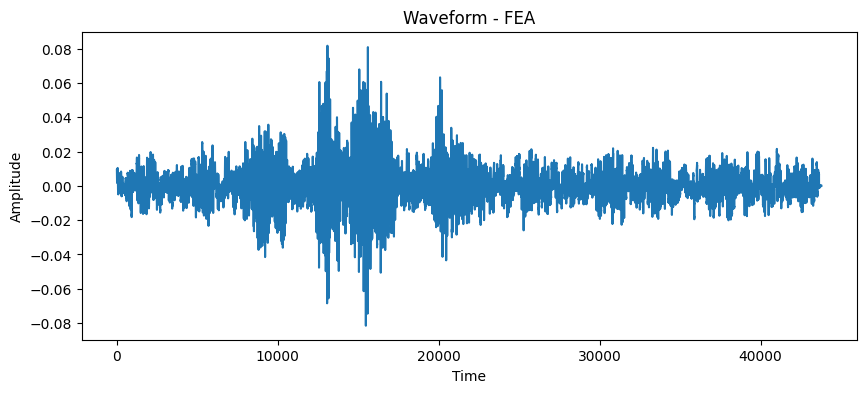

Fear Audio Sample



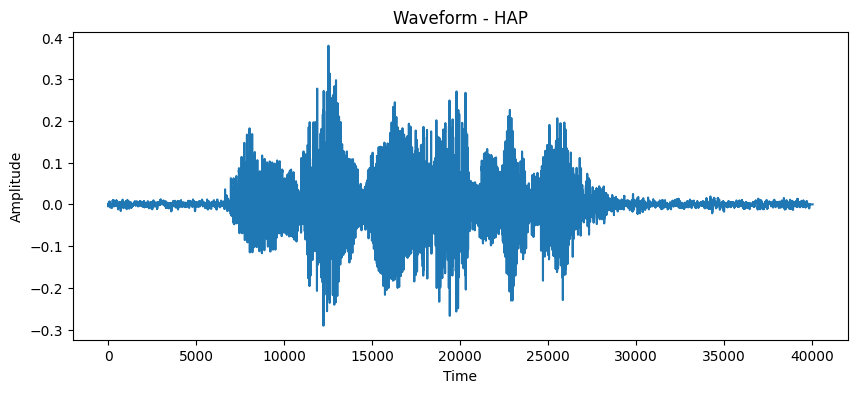

Happy Audio Sample



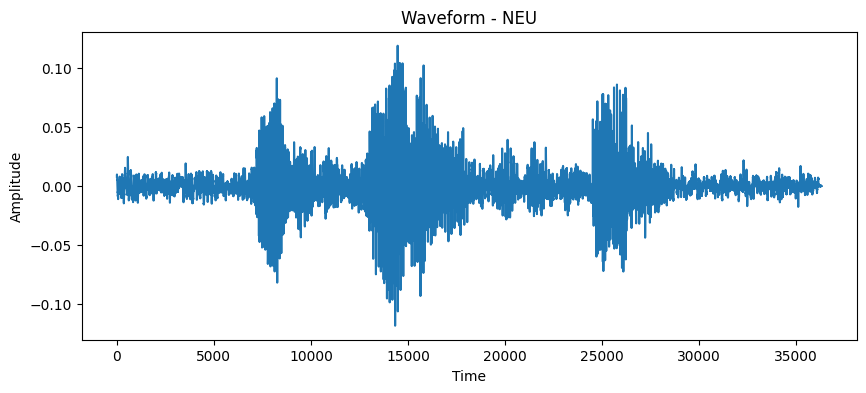

Neutral Audio Sample



In [2]:
import os
import random
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt

# Set the path to the CREMA dataset directory
crema_dir = 'Crema'

# Function to load audio file
def load_audio_file(file_path):
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    return audio, sr

# Function to listen to audio
def listen_to_audio(file_path):
    audio, sr = load_audio_file(file_path)
    return ipd.Audio(data=audio, rate=sr)

# Function to display waveform with label
def plot_waveform(audio, sr, class_label):
    plt.figure(figsize=(10, 4))
    plt.plot(audio)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'Waveform - {class_label}')
    plt.show()

# Function to listen to a random audio file for a given class
def listen_to_file_by_class(class_label):
    files = os.listdir(crema_dir)
    class_files = [file for file in files if file.endswith('.wav') and class_label in file]
    if class_files:
        random_file = random.choice(class_files)
        file_path = os.path.join(crema_dir, random_file)
        audio, sr = load_audio_file(file_path)
        plot_waveform(audio, sr, class_label)
        return listen_to_audio(file_path)
    else:
        print(f"No files found for class '{class_label}'.")

# Dictionary of class labels and their descriptions
class_labels = {
    'SAD': 'Sadness',
    'ANG': 'Angry',
    'DIS': 'Disgust',
    'FEA': 'Fear',
    'HAP': 'Happy',
    'NEU': 'Neutral'
}

# Listen to an audio example for each class
for class_label, class_description in class_labels.items():
    audio = listen_to_file_by_class(class_label)
    print(f'{class_description} Audio Sample\n')
    display(audio)

In [3]:
import os
import random
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

# Set the seed for reproducibility
random.seed(42)

# Function to load audio file
def load_audio_file(file_path):
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    return audio, sr

# Function to extract time domain features
def extract_time_domain_features(audio, sr):
    # Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio).mean()

    # Energy
    energy = np.sum(audio ** 2) / len(audio)

    return zero_crossing_rate, energy

# Function to extract Mel spectrogram feature
def extract_mel_spectrogram(audio, sr):
    spectrogram = np.abs(librosa.stft(audio))
    mel_spectrogram = librosa.feature.melspectrogram(S=spectrogram, sr=sr)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return mel_spectrogram_db

# Directory containing the audio files
main_dir = 'Crema'

# List to store the features and labels
labels = []
time_features = []
spectrogram_features = []
energy_features = []

max_frames = 0  # Maximum number of frames among all spectrograms

# Extract features for each audio file
for file_name in os.listdir(main_dir):
    file_path = os.path.join(main_dir, file_name)
    audio, sr = load_audio_file(file_path)
    label = file_name.split('_')[2]

    # Extract time domain features
    zero_crossing_rate, energy = extract_time_domain_features(audio, sr)

    # Extract Mel spectrogram feature
    mel_spectrogram = extract_mel_spectrogram(audio, sr)

    # Update the maximum number of frames
    max_frames = max(max_frames, mel_spectrogram.shape[1])

    # Store the features and labels
    labels.append(label)
    time_features.append(zero_crossing_rate)
    spectrogram_features.append(mel_spectrogram)
    energy_features.append(energy)

# Pad or truncate each spectrogram to the maximum number of frames
padded_spectrograms = []
for spectrogram in spectrogram_features:
    if spectrogram.shape[1] < max_frames:
        # Pad with zeros
        padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, max_frames - spectrogram.shape[1])) , mode='constant')
    elif spectrogram.shape[1] > max_frames:
        # Truncate
        padded_spectrogram = spectrogram[:, :max_frames]
    else:
        # No change needed
        padded_spectrogram = spectrogram
    padded_spectrograms.append(padded_spectrogram)

padded_spectrograms = np.array(padded_spectrograms)

# Convert the features and labels to numpy arrays
labels = np.array(labels)
time_features = np.array(time_features)
energy_features = np.array(energy_features)

# Print the shapes of the features and labels
print(f"Labels shape: {labels.shape}")
print(f"Time features shape: {time_features.shape}")
print(f"Energy features shape: {energy_features.shape}")
print(f"Padded spectrograms shape: {padded_spectrograms.shape}")

Labels shape: (7442,)
Time features shape: (7442,)
Energy features shape: (7442,)
Padded spectrograms shape: (7442, 128, 157)


In [4]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder,StandardScaler
lb=LabelEncoder()
# Split the data into training/validation and testing sets
Y=np_utils.to_categorical(lb.fit_transform(labels))
X_trainval, X_test, y_trainval, y_test = train_test_split(time_features, Y, test_size=0.3, random_state=42, stratify=labels)

# Split the training/validation data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.05, random_state=42, stratify=y_trainval)

# Print the shapes of the training, validation, and testing sets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

2023-05-27 14:06:04.881900: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-27 14:06:05.376362: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-27 14:06:05.378569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 14:06:08.656929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Training set: (4948,), (4948, 6)
Validation set: (261,), (261, 6)
Testing set: (2233,), (2233, 6)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense
X_train=np.expand_dims(X_train,axis=1)
X_val=np.expand_dims(X_val,axis=1)
X_test=np.expand_dims(X_test,axis=1)
X_train.shape, X_test.shape, X_val.shape
# Define the model architecture
model = Sequential()
model.add(Conv1D(512, kernel_size=5, strides=5, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPool1D(pool_size=5, strides=2, padding='same'))
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=5, strides=2, padding='same'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=5, strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

: 

: 

In [ ]:
# Train the model for 250 epochs
model.fit(X_train, y_train, batch_size=32, epochs=60, validation_data=(X_val, y_val))

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

# Calculate the F1 score
f1score = f1_score(y_test_labels, y_pred_labels, average='weighted')
print("F1 Score:", f1score)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Get the class labels
class_labels = ['Sadness','Angry','Disgust','Fear','Happy','Neutral']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Find the most confusing classes
np.fill_diagonal(cm, 0)  # Exclude correct predictions from the confusion matrix
most_confusing_classes = np.unravel_index(np.argmax(cm), cm.shape)
confusing_class1 = class_labels[most_confusing_classes[0]]
confusing_class2 = class_labels[most_confusing_classes[1]]
print("The most confusing classes are:", confusing_class1, "and", confusing_class2)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder,StandardScaler
lb=LabelEncoder()
# Split the data into training/validation and testing sets
Y=np_utils.to_categorical(lb.fit_transform(labels))
X_trainval, X_test, y_trainval, y_test = train_test_split(energy_features, Y, test_size=0.3, random_state=42, stratify=labels)

# Split the training/validation data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.05, random_state=42, stratify=y_trainval)

# Print the shapes of the training, validation, and testing sets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense
X_train=np.expand_dims(X_train,axis=1)
X_val=np.expand_dims(X_val,axis=1)
X_test=np.expand_dims(X_test,axis=1)
X_train.shape, X_test.shape, X_val.shape
# Define the model architecture
model_nrg = Sequential()
model_nrg.add(Conv1D(512, kernel_size=5, strides=5, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model_nrg.add(MaxPool1D(pool_size=5, strides=2, padding='same'))
model_nrg.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model_nrg.add(MaxPool1D(pool_size=5, strides=2, padding='same'))
model_nrg.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model_nrg.add(MaxPool1D(pool_size=5, strides=2, padding='same'))
model_nrg.add(Flatten())
model_nrg.add(Dense(256, activation='relu'))
model_nrg.add(Dense(6, activation='softmax'))

# Compile the model
model_nrg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_nrg.summary()

In [ ]:
# Train the model for 250 epochs
model_nrg.fit(X_train, y_train, batch_size=32, epochs=60, validation_data=(X_val, y_val))

In [ ]:
loss, accuracy = model_nrg.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test data
y_pred = model_nrg.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

# Calculate the F1 score
f1score = f1_score(y_test_labels, y_pred_labels, average='weighted')
print("F1 Score:", f1score)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Get the class labels
class_labels = ['Sadness','Angry','Disgust','Fear','Happy','Neutral']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Find the most confusing classes
np.fill_diagonal(cm, 0)  # Exclude correct predictions from the confusion matrix
most_confusing_classes = np.unravel_index(np.argmax(cm), cm.shape)
confusing_class1 = class_labels[most_confusing_classes[0]]
confusing_class2 = class_labels[most_confusing_classes[1]]
print("The most confusing classes are:", confusing_class1, "and", confusing_class2)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder,StandardScaler
lb=LabelEncoder()
# Split the data into training/validation and testing sets
Y=np_utils.to_categorical(lb.fit_transform(labels))
X_trainval, X_test, y_trainval, y_test = train_test_split(padded_spectrograms, Y, test_size=0.3, random_state=42, stratify=labels)

# Split the training/validation data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.05, random_state=42, stratify=y_trainval)

# Print the shapes of the training, validation, and testing sets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_train.shape, X_test.shape, X_val.shape

# Define the model architecture
model_msg = Sequential()
model_msg.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model_msg.add(MaxPooling2D(pool_size=(2, 2)))
model_msg.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model_msg.add(MaxPooling2D(pool_size=(2, 2)))
model_msg.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model_msg.add(MaxPooling2D(pool_size=(2, 2)))
model_msg.add(Flatten())
model_msg.add(Dense(256, activation='relu'))
model_msg.add(Dense(6, activation='softmax'))

# Compile the model
model_msg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_msg.summary()

In [ ]:
# Train the model for 250 epochs
model_msg.fit(X_train, y_train, batch_size=32, epochs=60, validation_data=(X_val, y_val))

In [ ]:
loss, accuracy = model_msg.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test data
y_pred = model_msg.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

# Calculate the F1 score
f1score = f1_score(y_test_labels, y_pred_labels, average='weighted')
print("F1 Score:", f1score)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Get the class labels
class_labels = ['Sadness','Angry','Disgust','Fear','Happy','Neutral']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Find the most confusing classes
np.fill_diagonal(cm, 0)  # Exclude correct predictions from the confusion matrix
most_confusing_classes = np.unravel_index(np.argmax(cm), cm.shape)
confusing_class1 = class_labels[most_confusing_classes[0]]
confusing_class2 = class_labels[most_confusing_classes[1]]
print("The most confusing classes are:", confusing_class1, "and", confusing_class2)